# Demo of the evolution model

The code in [amitosis.py](amitosis.py) and in this notebook was last tested with:

* python version 3.7.12
* numpy 1.20.3
* pandas 1.3.5
* matplotlib 3.4.2
* seaborn 0.11.1

Below we illustrate how to conduct the simulations used to generate Figure 5.  

## Parameters

* Genomic mutation rate: $U = 0.03$
* Beneficial effect of a mutation: $s = 0.03$
* Population size: $N=3000$
* Number of replicate populations: 16
* Number of fitness loci: $L=200$
* Number of loci fixed for a beneficial mutation: $K = 5$

In [1]:
run amitosis

In [2]:
sns.set_style('ticks')
sns.set_context('talk')

## Parental population

In [21]:
nReps = 16
pop = Populations(nReps=nReps, N=3000, nLoci=200, ploidy=45, genomic_mu=.03, selcoef=.03, amitosis=True)
for i in range(nReps):
    for j in range(5):  
        pop.soma[i,:,j] += 45
pop.get_fitness()
pop.collect_data()
data = pop.evolve(1000, 10) 
data

,generation,fitness_mean,fitness_std,nReps,N,nLoci,ploidy,genomic_mu,selcoef,amitosis
0,0,1.159274,0.000000,16,3000,200,45,0.03,0.03,True
1,10,1.159491,0.000028,16,3000,200,45,0.03,0.03,True
2,20,1.159750,0.000092,16,3000,200,45,0.03,0.03,True
3,30,1.160048,0.000160,16,3000,200,45,0.03,0.03,True
4,40,1.160372,0.000225,16,3000,200,45,0.03,0.03,True
...,...,...,...,...,...,...,...,...,...,...
96,960,1.581670,0.060687,16,3000,200,45,0.03,0.03,True
97,970,1.586754,0.059756,16,3000,200,45,0.03,0.03,True
98,980,1.591631,0.059141,16,3000,200,45,0.03,0.03,True
99,990,1.597131,0.058372,16,3000,200,45,0.03,0.03,True


## Progeny population

In [20]:
nReps = 16
pop = Populations(nReps=nReps, N=3000, nLoci=200, ploidy=45, genomic_mu=.03, selcoef=.03, amitosis=True)
for i in range(nReps):
    for j in range(5):  
        pop.soma[i,:,j] += 22
    for j in range(5, 10):  
        pop.soma[i,:,j] += 23
pop.get_fitness()
pop.collect_data()
data2 = pop.evolve(1000, 10) 
data2

,generation,fitness_mean,fitness_std,nReps,N,nLoci,ploidy,genomic_mu,selcoef,amitosis
0,0,1.160540,0.000000,16,3000,200,45,0.03,0.03,True
1,10,1.161708,0.000670,16,3000,200,45,0.03,0.03,True
2,20,1.165567,0.001134,16,3000,200,45,0.03,0.03,True
3,30,1.171817,0.001151,16,3000,200,45,0.03,0.03,True
4,40,1.180515,0.001659,16,3000,200,45,0.03,0.03,True
...,...,...,...,...,...,...,...,...,...,...
96,960,1.792307,0.078516,16,3000,200,45,0.03,0.03,True
97,970,1.798844,0.079890,16,3000,200,45,0.03,0.03,True
98,980,1.806667,0.080934,16,3000,200,45,0.03,0.03,True
99,990,1.814319,0.082675,16,3000,200,45,0.03,0.03,True


## Plot

In [15]:
red = sns.xkcd_rgb['pale red']
gre = sns.xkcd_rgb['light green'] 

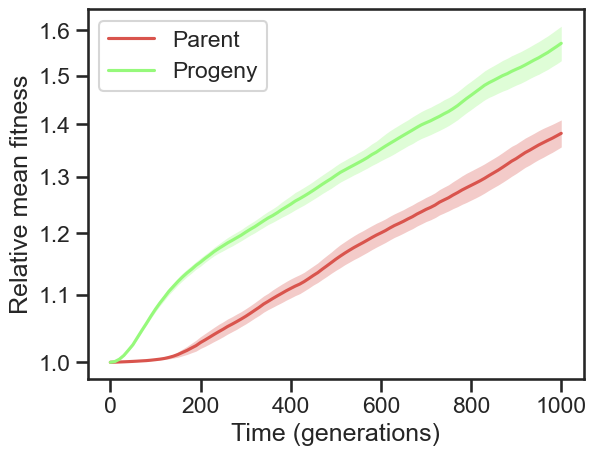

In [23]:
t = data['generation']
w1 = data['fitness_mean'] / data['fitness_mean'][0]
w2 = data2['fitness_mean'] / data2['fitness_mean'][0]
w1ci = 2.13145 * (data['fitness_std'] / data['fitness_mean'][0]) / 4
w2ci = 2.13145 * (data2['fitness_std'] / data2['fitness_mean'][0]) / 4 
plt.semilogy(t, w1, label='Parent', color=red)
plt.fill_between(t, w1 - w1ci, w1 + w1ci, alpha=.3, color=red, lw=.001)
plt.plot(t, w2, label='Progeny', color=gre)
plt.fill_between(t, w2 - w2ci, w2 + w2ci, alpha=.3, color=gre, lw=.001)
plt.yticks(ticks=np.arange(1, 1.61, .1), labels=np.arange(1, 1.61, .1).round(2))
plt.ylabel('Relative mean fitness')
plt.xlabel('Time (generations)')
plt.legend();